## Overview

The F-Statistic of a Linear Regression seeks to answer "Does the introduction of these variables give us greater information gain when trying to explain variation in our target?"

I like the way that [Ben Lambert](https://www.youtube.com/watch?v=ie-MYQp1Nic) explains and will paraphrase.

First you make two models-- a *restricted model* that's just the intercept and an *unrestricted model* that includes new `x_i` values

$R: y = \alpha $

$U: y = \alpha + \beta_1 x_1 + \beta_2 x_2$

Then our Null Hypothesis states that none of the coefficients in `U` matter and `B_1 = B_2 = 0` (but can extend to arbitrarily-many Beta values). Equivalently, the alternative hypothesis states that `B_i != 0` for either Beta.

And so we start by calculating the Sum of Squared Residuals ([see notes on R-Squared for refresher](https://napsterinblue.github.io/notes/machine_learning/regression/r_squared/)) for both the Restricted and Unrestricted models.

By definition, then SSR for the Restricted will be higher-- addition of any X variables will account for *some* increase in predictive power even if miniscule.

Armed with these two, **the F-Statistic is simply the ratio of explained variance and unexplained variance**, and is calculated as

$F = \frac{SSR_R - SSR_U}{SSR_U}$

Well, almost.

We also, critically, normalize the numerator and denominator based on `p`, the number of `x` features we're looking at, and `n`, the number of observations we have. This helps us account for degrees of freedom and looks like the following:

$F = \frac{(SSR_R - SSR_U)/p}{SSR_U/(n-p-1)}$

## Interpretation

Plugging this into your favorite statistical computing software will yield a value that can take on wildly-different values. Conceptually, let's imagine two extremes:

- The X values don't give us anything useful. This means that the numerator (the information gain of adding them to the model) is small, therefore the whole fraction is small (often around `1` or so)
- On the other hand, if there's a huge improvement, you might see F values in the hundreds, if not thousands.

Generally, the F-statistic follows a distribution that depends on the degrees of freedom for both the numerator and denominator, and has a shape that looks like the following.

[Source of the image](https://www.youtube.com/watch?v=G_RDxAZJ-ug)

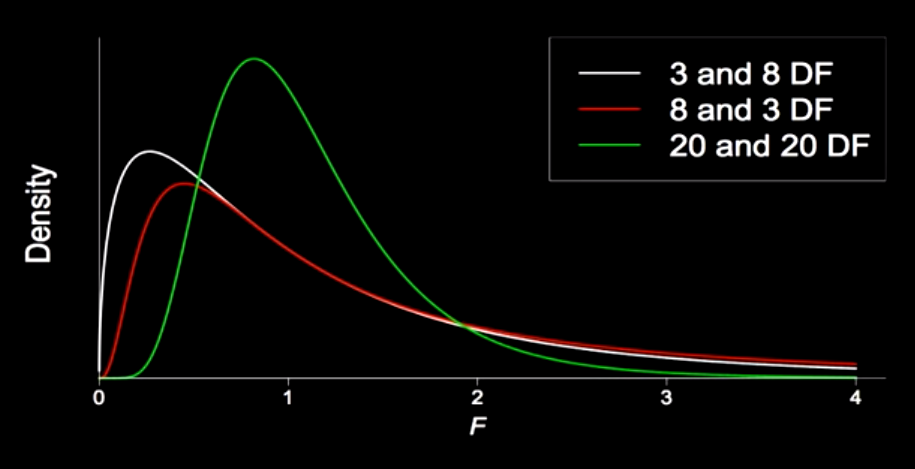

In [1]:
from IPython.display import Image
Image('images/f_dists.PNG')

## Relationship to t-statistic

The F and t statistics feel conceptually adjacent. But whereas F examines the effect of *multiple* attributes on your model, the t simply looks at one.

From a notation standpoint, if you had a model with an intercept and one `x` and wanted to observe the F statistic when introducing another `x`, you'd have a difference in 1 degree of freedom (numerator), and 2 degrees of freedom (minus the standard `1` in the denominator), thus

$F_{1, N-3}$

As far as the output goes, this is functionally equivalent to finding the t-statistic for the same degrees of freedom (N-3), and squaring it. [Source](https://www.youtube.com/watch?v=OzGuXV_qZHg)

### An Example

If we whip up a quick Linear Regression using the `statsmodels.api` and the `boston` dataset within `sklearn`, we get access to a very clean object that we can use to interrogate the F-statistic for the model as a whole

In [2]:
import statsmodels.api as sm
from sklearn.datasets import load_boston

data = load_boston()

X = data['data']
X = sm.add_constant(X)

est = sm.OLS(data['target'], X)
est = est.fit()

est.fvalue

108.07666617432622

But we also can see, using `.summary()`, the t-statistic for each of the attributes of our model. This is the same as omitting the variable, calculating the F-statistic, then taking the square root (and changing the sign, where appropriate).

In other words, this is the same as the partial effect of adding this variable to the mix.

In [3]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 09 Sep 2019   Prob (F-statistic):          6.72e-135
Time:                        16:44:05   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.000      26.432      46.487
x1            -0.1080      0.033     -3.287      0.001      -0.173      -0.043
x2             0.0464      0.014      3.382      0.001       0.019       0.073
x3             0.0206      0.061      0.334      0.738      -0.100       0.141
x4             2.6867      0.862      3.118      0.002       0.994       4.380
x5           -17.7666      3.820     -4.651      0.000     -25.272     -10.262
x6             3.8099      0.418      9.116      0.000       2.989       4.631
x7             0.0007      0.013      0.052      0.958      -0.025       0.027
x8            -1.4756      0.199     -7.398      0.000      -1.867      -1.084
x9             0.3060      0.066      4.613      0.000       0.176       0.436
x10           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
x11           -0.9527      0.131     -7.283      0.000      -1.210      -0.696
x12            0.0093      0.003      3.467      0.001       0.004       0.015
x13           -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### A warning about `.summary()` method and t-statistics

It's not enough to consider all of the t-statistics for each coefficient.

Consider the case when we build a Linear Regression off of 100 different attributes and that our null hypothesis is true-- each of them are unrelated to the target.

Recall that the p-value is shorthood for "probability that we observed this statistic under the null hypothesis." We often reject values less than `0.05`, but considering the joint probability of 100 attributes, it's *likely* that we incidentally see one of them coming in under this cutoff-- despite not being valid.

If our criteria for "is this model valid?" is throwing a big ol' OR statement on all of the p-values and hoping for a bite, we're likely to come to a false conclusion.

On the other hand, looking at the F statistic, because of the normalization by `n` and `p`, accounts for the observation and dimension size.